# Heckman Problem Set 4

In [241]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.stats import chi2
import statsmodels as sm
import statsmodels.api as smapi
from scipy.spatial import distance

%matplotlib inline

## Question 3

In [2]:
####Pull data####
data_1 = pd.read_excel('PS4_Data.xlsx',sheet_name= 'DataSet0')
data_2 = pd.read_excel('PS4_Data.xlsx',sheet_name= 'DataSet1')
data_3 = pd.read_excel('PS4_Data.xlsx',sheet_name= 'DataSet2')
data_4 = pd.read_excel('PS4_Data.xlsx',sheet_name= 'DataSet3')

column_names = ['obs','Y','D','X1','X2','Z1','Z2']

data_1.columns = column_names
data_2.columns = column_names
data_3.columns = column_names
data_4.columns = column_names

### Part a, b, and half of c

Below we run a probit model regression D on Z and X to get the propoensity score. Then we then plot histograms of the propensity scores. Finally, we us the use the Mahalanbois distance to match observations with their nearest neighbor (denote $Y_i$'s nearest neighbour as $\hat Y_i$). The we calculate observations specific treatment effects as,
$$\hat TE_i = (2D_i - 1)(Y_i - \hat Y_i)$$


Part a: Probit
Optimization terminated successfully.
         Current function value: 0.588268
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                      D   No. Observations:                10000
Model:                         Probit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Tue, 02 Jun 2020   Pseudo R-squ.:                 0.09027
Time:                        18:55:54   Log-Likelihood:                -5882.7
converged:                       True   LL-Null:                       -6466.4
Covariance Type:            nonrobust   LLR p-value:                8.683e-253
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1             0.2879      0.013     21.572      0.000       0.262       0.314
X2           

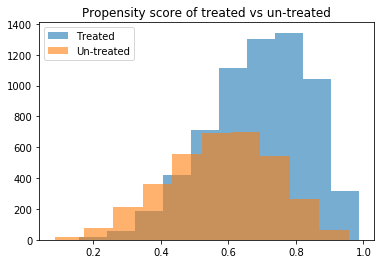


Part a: Probit
Optimization terminated successfully.
         Current function value: 0.544252
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                      D   No. Observations:                 1000
Model:                         Probit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Tue, 02 Jun 2020   Pseudo R-squ.:                  0.1804
Time:                        18:55:55   Log-Likelihood:                -544.25
converged:                       True   LL-Null:                       -664.06
Covariance Type:            nonrobust   LLR p-value:                 1.147e-51
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1             0.0436      4.552      0.010      0.992      -8.879       8.966
X2           

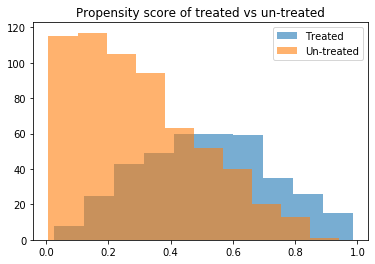


Part a: Probit
Optimization terminated successfully.
         Current function value: 0.098024
         Iterations 10
                          Probit Regression Results                           
Dep. Variable:                      D   No. Observations:               100000
Model:                         Probit   Df Residuals:                    99996
Method:                           MLE   Df Model:                            3
Date:                Tue, 02 Jun 2020   Pseudo R-squ.:                  0.8269
Time:                        18:55:57   Log-Likelihood:                -9802.4
converged:                       True   LL-Null:                       -56620.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1            -2.1513      0.022    -97.930      0.000      -2.194      -2.108
X2          

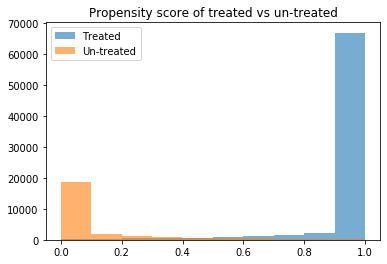


Part a: Probit
Optimization terminated successfully.
         Current function value: 0.384732
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                      D   No. Observations:                10000
Model:                         Probit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Tue, 02 Jun 2020   Pseudo R-squ.:                  0.4335
Time:                        18:55:58   Log-Likelihood:                -3847.3
converged:                       True   LL-Null:                       -6791.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1             0.0661      0.002     35.192      0.000       0.062       0.070
X2           

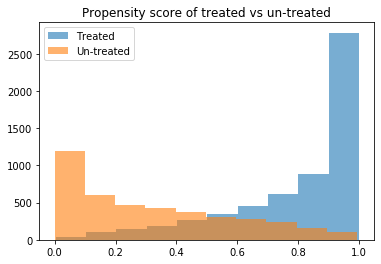

In [240]:
##BE CAREFUL BEFORE YOU RUN THIS. IT WILL TAKE AROUND 2 HOURS.
database_list = [data_1, data_2, data_3, data_4]
re_match = "no"
count=1

for data in database_list:
    
    ###prepare data
    w = data[['X1','X2','Z1','Z2']]
    y = data[['D']]

    print('')
    print('Part a: Probit')
    
    ###run probit model and print results
    model = sm.discrete.discrete_model.Probit(y, w)
    results = model.fit()
    print(results.summary())
    
    
    ###plot p-scores for two groups
    print('')
    print('Part b: Histogram')
    
    data['p_score'] = results.predict() #calcluate fitted values
    
    fig, ax = plt.subplots()
    plt.hist(data[(data['D']==1)]['p_score'],label='Treated',alpha=0.6)
    plt.hist(data[(data['D']==0)]['p_score'],label='Un-treated',alpha=0.6)
    ax.set_title('Propensity score of treated vs un-treated')
    ax.legend(loc='best')
    plt.savefig('Problem Set 4 Charts/3c db' + str(count) + ' hist.png')
    plt.show()
    
    count = count + 1
    
    if re_match=="yes":
        ###match and calculate observation TEs
        #calculate covriance matrix invesre for distance (makes code faster)
        Σ = np.cov(np.array(data[['X1','X2','Z1','Z2']]).transpose())
        Σ_inv = np.linalg.inv(Σ)
        data['TE'] = np.nan
        σ_x1, σ_x2, σ_z1, σ_z2 = Σ[0,0]**0.5, Σ[1,1]**0.5, Σ[2,2]**0.5, Σ[3,3]**0.5

        #convert panda to array to speed up loop
        V_1 = data[data['D'] == 1]
        V_1 = np.array(V_1[['X1','X2','Z1','Z2']])
        V_0 = data[data['D'] == 0]
        V_0 = np.array(V_0[['X1','X2','Z1','Z2']])
        V = np.array(data[['X1','X2','Z1','Z2']])
        D = np.array(data[['D']])
        factor = 0.5

        for i in range(len(data)):

            if i%1000==0:
                print(str(i))

            #extract element
            v_1 = V[i]#np.array(data[['X1','X2','Z1','Z2']].iloc[i])
            d_id = D[i][0]

            if d_id == 1:
                V_compare = [v for v in V_0 if abs(v[0]-v_1[0])/σ_x1<factor and abs(v[1]-v_1[1])/σ_x2<factor and abs(v[2]-v_1[2])/σ_z1<factor and abs(v[3]-v_1[3])/σ_z2<factor]
            else:
                V_compare = [v for v in V_1 if abs(v[0]-v_1[0])/σ_x1<factor and abs(v[1]-v_1[1])/σ_x2<factor and abs(v[2]-v_1[2])/σ_z1<factor and abs(v[3]-v_1[3])/σ_z2<factor]

            #look for nearest neighbour
            current_best = 99999999
            nn_loc = 0

            for v_2 in V_compare:
                if distance.mahalanobis(v_1, v_2, Σ_inv)<current_best and np.where(V == v_2)[0][0]!=i:
                    nn_loc = np.where(V == v_2)[0][0]
                    current_best = distance.mahalanobis(v_1, v_2, Σ_inv)

            data.iloc[i, data.columns.get_loc('TE')] = (2*data.iloc[i, data.columns.get_loc('D')]-1)*(data.iloc[i, data.columns.get_loc('Y')]-data.iloc[nn_loc, data.columns.get_loc('Y')])

We now use the observation "treatment effect estimates" to construct estimators for the standard program evaluation literature estimands,
\begin{align*}
    ATE(p) = MTE(p) =& \frac{1}{\sum_{i=1}^N \mathbf{1}\{p_i=u\}} \sum_{i=1}^N \mathbf{1}\{p_i=u\}\hat TE_i\\
    TOT(p) =& \frac{1}{\sum_{i=1}^N D_i\mathbf{1}\{p_i=u\} } \sum_{i=1}^N \mathbf{1}\{p_i=u\}D_i \hat TE_i\\
    TUT(p) =& \frac{1}{\sum_{i=1}^N (1-D_i)\mathbf{1}\{p_i=u\}} \sum_{i=1}^N \mathbf{1}\{p_i=u\}(1-D_i)\hat TE_i\\
    AMTE =& \frac{1}{N} \sum_{i=1}^N \hat TE_i
\end{align*}

In [232]:
def estimator(data, estimator = 'ATE',p_score = 'p_score',TE = 'TE', D = 'D', p_l = 0, p_u = 1, bins = 20, graph = "yes", return_values = "no"):

    if estimator == 'AMTE':
        df = data[(data[p_score]<=p_u)]
        df = df[df[p_score] >= p_l][TE]
        AMTE = np.mean(df)
        values = np.array([AMTE,AMTE])
        p_values = np.array([p_l,p_u])
        return values, p_values
    
    p_values = np.linspace(p_l, p_u, bins + 1)
    values = np.zeros(bins+1)
    if estimator == 'TOT':
        data = data[data[D]==1]
    if estimator == 'TUT':
        data = data[data[D]==0]
        
    for i in range(bins):
        p = p_values[i]
        df = data[(data[p_score]<=p + 1/bins)]
        df = df[df[p_score] >= p - 1/bins][TE]
        values[i] = np.mean(df)
    
    #drop nan values
    p_values = np.delete(p_values, np.where(np.isnan(values)))
    values = np.delete(values, np.where(np.isnan(values)))
    

    
    if graph == "yes":
        fig, ax = plt.subplots()
        ax.plot(p_values, values, linewidth=2, alpha=0.6, label=estimator)
        ax.legend(loc='best')
        ax.set_title(estimator + ' vs propensity score')
        ax.set_xlabel('Propensity Score')
        plt.show()
    
    if return_values == "yes":
        return values, p_values


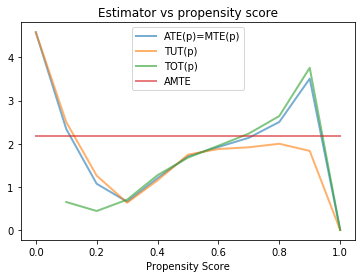

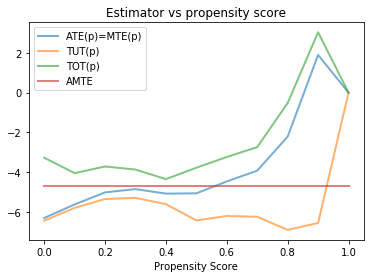

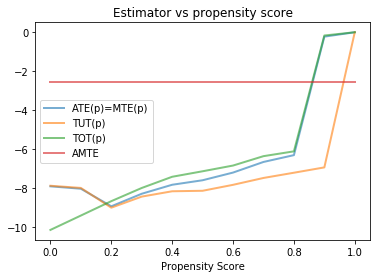

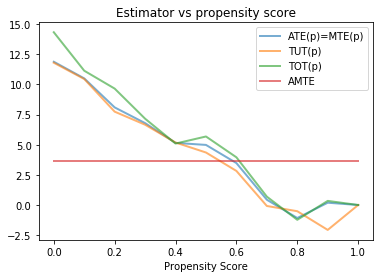

In [234]:
bin_size = 10
p_l = 0
p_u = 1

count = 1
for data in database_list:
    ATE = estimator(data, estimator = 'ATE', p_l = p_l, p_u = p_u, bins = bin_size, graph = 'no', return_values = 'yes')
    TUT = estimator(data, estimator = 'TUT', p_l = p_l, p_u = p_u, bins = bin_size, graph = 'no', return_values = 'yes')
    TOT = estimator(data, estimator = 'TOT', p_l = p_l, p_u = p_u, bins = bin_size, graph = 'no', return_values = 'yes')
    AMTE = estimator(data, estimator = 'AMTE', p_l = p_l, p_u = p_u, graph = 'no', return_values = 'yes')

    fig, ax = plt.subplots()
    ax.plot(ATE[1], ATE[0], linewidth=2, alpha=0.6, label='ATE(p)=MTE(p)')
    ax.plot(TUT[1], TUT[0], linewidth=2, alpha=0.6, label='TUT(p)')
    ax.plot(TOT[1], TOT[0], linewidth=2, alpha=0.6, label='TOT(p)')
    ax.plot(AMTE[1], AMTE[0], linewidth=2, alpha=0.6, label='AMTE')
    ax.legend(loc='best')
    ax.set_title('Estimator vs propensity score')
    ax.set_xlabel('Propensity Score')
    plt.savefig('Problem Set 4 Charts/3c_db' + str(count) + '_est_pscore.png')
    plt.show()
    
    count = count + 1

Rosenbaum and Rubin (1983) showed that if,
$$(Y_1,Y_0)\perp D|(X,Z) \quad \text{and} \quad 0<Pr(D=1|X,Z)<1$$
then,
$$(Y_1,Y_0)\perp D|P(D=1|X,Z)$$

Therfore matching on $(X,Z)$ and matching on $P(D=1|X,Z)$ are deeply connected.

### Part d/e


ATE/AMTE regression
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     4226.
Date:                Tue, 02 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:12:03   Log-Likelihood:                -26376.
No. Observations:               10000   AIC:                         5.276e+04
Df Residuals:                    9998   BIC:                         5.277e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0297      0.14

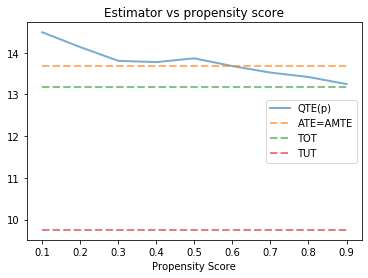


ATE/AMTE regression
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.041
Date:                Tue, 02 Jun 2020   Prob (F-statistic):              0.153
Time:                        19:12:04   Log-Likelihood:                -2649.3
No. Observations:                1000   AIC:                             5303.
Df Residuals:                     998   BIC:                             5312.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9774      0.21

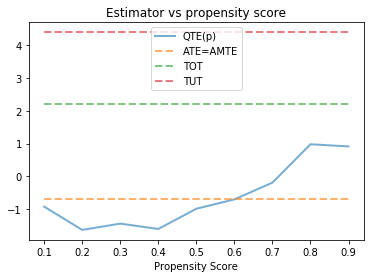


ATE/AMTE regression
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     136.0
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           2.05e-31
Time:                        19:12:05   Log-Likelihood:            -3.4221e+05
No. Observations:              100000   AIC:                         6.844e+05
Df Residuals:                   99998   BIC:                         6.844e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6750      0.04

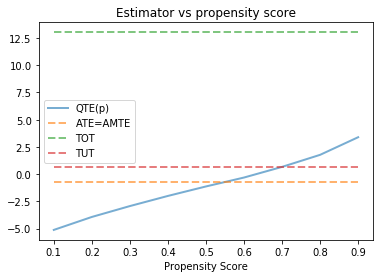


ATE/AMTE regression
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     966.5
Date:                Tue, 02 Jun 2020   Prob (F-statistic):          1.22e-202
Time:                        19:12:12   Log-Likelihood:                -42248.
No. Observations:               10000   AIC:                         8.450e+04
Df Residuals:                    9998   BIC:                         8.451e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4502      0.33

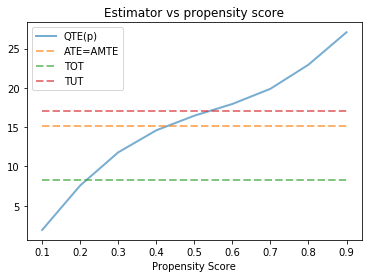

In [250]:
for data in database_list:
    
    #ATE
    print('')
    print('ATE/AMTE regression')
    X = data['p_score']
    X = smapi.add_constant(X)
    y = data['Y']
    model = smapi.OLS(y, X)
    results = model.fit()
    print(results.summary())
    ATE_est = results.params[1]
    
    #Quantile Regression Estimates
    model = sm.regression.quantile_regression.QuantReg(y,X)
    q_est = np.zeros(9)
    quantile = np.linspace(0.1, 0.9, 9)
    for i in range(len(q_est)):
        results = model.fit(q = quantile[i])
        q_est[i] = results.params[1]

    #TUT
    print('')
    print('TUT regression')
    df = data[(data['D'] == 0)]
    X = df['p_score']
    X = smapi.add_constant(X)
    y = df['Y']
    model = smapi.OLS(y, X)
    results = model.fit()
    print(results.summary())
    TUT_est = results.params[1]

    #TOT
    print('')
    print('TOT regression')
    df = data[(data['D'] == 1)]
    X = df['p_score']
    X = smapi.add_constant(X)
    y = df['Y']
    model = smapi.OLS(y, X)
    results = model.fit()
    print(results.summary())
    TOT_est = results.params[1]


    fig, ax = plt.subplots()
    ax.plot(quantile, q_est, linewidth=2, alpha=0.6, label='QTE(p)')
    ax.plot(np.array([0.1,0.9]), np.array([ATE_est,ATE_est]), linewidth=2, linestyle = "dashed", alpha=0.6, label='ATE=AMTE')
    ax.plot(np.array([0.1,0.9]), np.array([TOT_est,TOT_est]), linewidth=2, linestyle = "dashed", alpha=0.6, label='TOT')
    ax.plot(np.array([0.1,0.9]), np.array([TUT_est,TUT_est]), linewidth=2, linestyle = "dashed", alpha=0.6, label='TUT')
    ax.legend(loc='best')
    ax.set_title('Estimator vs propensity score')
    ax.set_xlabel('Propensity Score')
    plt.savefig('Problem Set 4 Charts/3d_db' + str(count) + '_qreg_plot.png')
    plt.show()

blah blah blah comparing estimates in c and d

### Part F

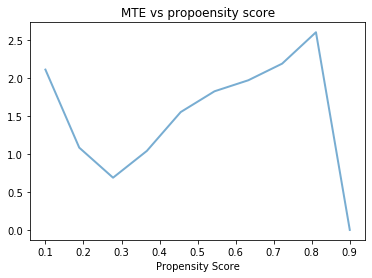

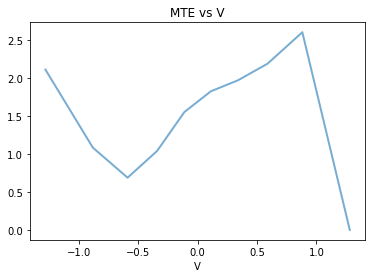

In [263]:
bin_no = 9
p_l = 0.1
p_u = 0.9

for data in [data_1]:#database_list:
    
    MTE = estimator(data, estimator = 'ATE', p_l = 0.1, p_u = 0.9, bins = bin_no, graph = 'no', return_values = 'yes')
    fig, ax = plt.subplots()
    ax.plot(MTE[1], MTE[0], linewidth=2, alpha=0.6, label='MTE(p)')
    ax.set_title('MTE vs propoensity score')
    ax.set_xlabel('Propensity Score')
    plt.show()
    
    MTE_x_2 = [norm.ppf(p) for p in MTE[1]]
    fig, ax = plt.subplots()
    ax.plot(MTE_x_2, MTE[0], linewidth=2, alpha=0.6, label='MTE(V)')
    ax.set_title('MTE vs V')
    ax.set_xlabel('V')
    plt.show()